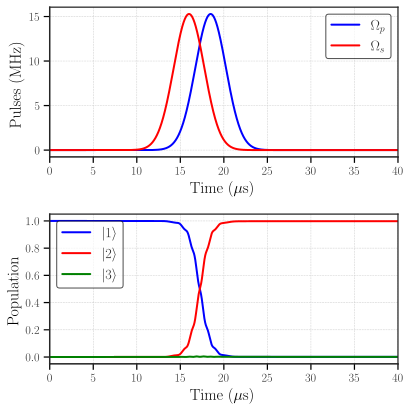

Parámetros óptimos: Omega13 = Omega23 = 15.2852 (MHz)
                    sigma = 1.7550 (μs)
Valor final población |1>: 0.0011
Valor final población |2>: 0.9978
Valor final población |3>: 0.0011
Tiempo para llegar al 99% del valor máximo de p2: 20.3060 μs
Tiempo total de la optimización: 82.6022 segundos


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import matplotlib as mpl
from matplotlib import rcParams
from scipy.optimize import minimize
import time  
import seaborn as sns

def initialize_plotting(style='whitegrid'):
    import IPython
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import seaborn as sns
 
    # Aplicar el estilo de Seaborn
    sns.set(style=style)

    # Estilos para gráficos
    label_size = 20
    mpl.rcParams['xtick.labelsize'] = label_size 
    mpl.rcParams['ytick.labelsize'] = label_size 
    plt.rc('font', family='serif')  # Fuente serif para el texto
    
    # figuras alta calidad jupyter
    %config InlineBackend.figure_format = 'svg' 
    
    mpl.rcParams.update({'font.size': 16})
    mpl.rcParams['text.usetex'] = True  
    
# Inicializamos el contador de tiempo
start_time = time.time()  

# Inicializamos los parámetros para el gráfico
initialize_plotting('ticks')

# Parámetros fijos (frecuencias en MHZ y tiempos en micro segundos)
Delta1 = 2 * np.pi * 0.2
Delta2 = Delta1
delta = Delta1 - Delta2
gamma1 = 1e-3
gamma2 = 1e-3
gamma3 = 0.1

# Parámetros iniciales
ts = 16

# Definimos la base para el sistema de tres niveles
ket1 = basis(3, 0)  # |1>
ket2 = basis(3, 1)  # |2>
ket3 = basis(3, 2)  # |3>

# Operadores sigma_ij = |i><j|
sigma_11 = ket1 * ket1.dag()  # |1><1|
sigma_22 = ket2 * ket2.dag()  # |2><2|
sigma_33 = ket3 * ket3.dag()  # |3><3|
sigma_31 = ket3 * ket1.dag()  # |3><1|
sigma_13 = ket1 * ket3.dag()  # |1><3|
sigma_32 = ket3 * ket2.dag()  # |3><2|
sigma_23 = ket2 * ket3.dag()  # |2><3|

# Operadores de colapso con sus respectivas tasas de decaimiento
c_ops = [
        np.sqrt(gamma1) * sigma_11,  # Colapso para |1>
        np.sqrt(gamma2) * sigma_22,  # Colapso para |2>
        np.sqrt(gamma3) * sigma_33   # Colapso para |3>
        ]

# Estado inicial |1>
psi0 = basis(3, 0)  # Starting in state |1>

# Definimos el arreglo para el tiempo
tlist = np.linspace(0, 40, 10000)

def run_simulation(params):
    Omega0, sigma = params
    Omega13, Omega23 = Omega0, Omega0
    tp = ts + np.sqrt(2) * sigma
    args = {'tp': tp, 'ts': ts, 'width': sigma}

    # Definimos los controles como funciones que dependen del tiempo
    Omega_p = lambda t, args: Omega13 * np.exp(-0.5 * ((t - args['tp']) / args['width']) ** 2)  # Pump pulse
    Omega_s = lambda t, args: Omega23 * np.exp(-0.5 * ((t - args['ts']) / args['width']) ** 2)  # Stokes pulse

    # Definimos cada componente del Hamiltoniano
    H0 = delta * sigma_22 + Delta1 * sigma_33
    Hp = (sigma_31 + sigma_13) / 2  # Acoplamiento para |1> <--> |3>, Omega_p
    Hs = (sigma_32 + sigma_23) / 2  # Acoplamiento para |2> <--> |3>, Omega_s

    # Hamiltoniano total dependiente del tiempo
    H = [H0, [Hp, Omega_p], [Hs, Omega_s]]

    # Resolvemos la ecuación maestra usando mesolve
    result = mesolve(H, psi0, tlist, c_ops, [basis(3, 0).proj(), basis(3, 1).proj(), basis(3, 2).proj()], args=args)
    p1 = np.abs(result.expect[0])
    p2 = np.abs(result.expect[1])
    p3 = np.abs(result.expect[2])
    
    # Valor final
    p1_final = p1[-1]
    p2_final = p2[-1]
    p3_final = p3[-1]
  
    return p1_final**2 + (1-p2_final)**2 + p3_final**2 

# Parámetros iniciales para la optimización
initial_params = [2 * np.pi * 1, 5]  # Omega0, sigma

# Realizamos la optimización
res = minimize(run_simulation, initial_params, bounds=[(0, 2*np.pi*10), (0, 5)], method='L-BFGS-B')

# Parámetros óptimos
Omega0_opt, sigma_opt = res.x
Omega13_opt, Omega23_opt = Omega0_opt, Omega0_opt
tp_opt = ts + np.sqrt(2) * sigma_opt
args_opt = {'tp': tp_opt, 'ts': ts, 'width': sigma_opt}

# Ejecutamos la simulación con los parámetros optimizados
Omega_p_opt = lambda t, args: Omega13_opt * np.exp(-0.5 * ((t - args['tp']) / args['width']) ** 2)
Omega_s_opt = lambda t, args: Omega23_opt * np.exp(-0.5 * ((t - args['ts']) / args['width']) ** 2)
Omega_p_values_opt = [Omega_p_opt(t, args_opt) for t in tlist]
Omega_s_values_opt = [Omega_s_opt(t, args_opt) for t in tlist]

# Definimos cada componente del Hamiltoniano optimizado
H0_opt = delta * sigma_22 + Delta1 * sigma_33
Hp_opt = (sigma_31 + sigma_13) / 2
Hs_opt = (sigma_32 + sigma_23) / 2
H_opt = [H0_opt, [Hp_opt, Omega_p_opt], [Hs_opt, Omega_s_opt]]

# Resolvemos la ecuación maestra usando mesolve con los parámetros optimizados
result_opt = mesolve(H_opt, psi0, tlist, c_ops, [basis(3, 0).proj(), basis(3, 1).proj(), basis(3, 2).proj()], args=args_opt)
p1_opt = np.abs(result_opt.expect[0])
p2_opt = np.abs(result_opt.expect[1])
p3_opt = np.abs(result_opt.expect[2])

# Crear figura y ejes para ambos gráficos
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), tight_layout=True)

# Primer gráfico: Campos de control optimizados
ax1.plot(tlist, Omega_p_values_opt, label=r"$\Omega_p$", color='blue', linewidth=2)
ax1.plot(tlist, Omega_s_values_opt, label=r"$\Omega_s$", color='red', linewidth=2)
ax1.set_xlabel("Time ($\mu$s)", fontsize=16, color='black')
ax1.set_ylabel("Pulses (MHz)", fontsize=16, color='black')
ax1.legend(loc='best', fontsize=14, frameon=True, framealpha=0.7, edgecolor='black')
ax1.set_xlim([min(tlist), max(tlist)])
ax1.tick_params(axis='both', which='major', labelsize=12, color='black')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax1.spines['left'].set_linewidth(1.5)
ax1.spines['bottom'].set_linewidth(1.5)

# Segundo gráfico: Poblaciones optimizadas
ax2.plot(tlist, p1_opt, label=r"$|1\rangle$", color='blue', linewidth=2)
ax2.plot(tlist, p2_opt, label=r"$|2\rangle$", color='red', linewidth=2)
ax2.plot(tlist, p3_opt, label=r"$|3\rangle$", color='green', linewidth=2)
ax2.set_xlabel("Time ($\mu$s)", fontsize=16, color='black')
ax2.set_ylabel("Population", fontsize=16, color='black')
ax2.legend(loc='best', fontsize=14, frameon=True, framealpha=0.7, edgecolor='black')
ax2.set_xlim([min(tlist), max(tlist)])
ax2.tick_params(axis='both', which='major', labelsize=12, color='black')
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
ax2.spines['left'].set_linewidth(1.5)
ax2.spines['bottom'].set_linewidth(1.5)

# Guardamos el gráfico en formato .svg (vectorial)
fig.savefig('STIRAP_OPT.svg', format='svg', dpi=1200)

# Mostrar los gráficos
plt.show()
fig.savefig('Optimized_STIRAP.svg', format='svg', dpi=1200)


# Valores óptimos
print(f"Parámetros óptimos: Omega13 = Omega23 = {Omega13_opt:.4f} (MHz)\n"
      f"                    sigma = {sigma_opt:.4f} (μs)")

# Imprimir los valores finales de cada población
print(f"Valor final población |1>: {p1_opt[-1]:.4f}")
print(f"Valor final población |2>: {p2_opt[-1]:.4f}")
print(f"Valor final población |3>: {p3_opt[-1]:.4f}")

# Calcular el tiempo para llegar al 99% del valor máximo de p2
p2_max_opt = np.max(p2_opt)
threshold_opt = 0.99 * p2_max_opt
time_to_reach_threshold_opt = tlist[np.where(p2_opt >= threshold_opt)[0][0]]
print(f"Tiempo para llegar al 99% del valor máximo de p2: {time_to_reach_threshold_opt:.4f} μs")

end_time = time.time()  # Detener el temporizador
simulation_time = end_time - start_time
print(f"Tiempo total de la optimización: {simulation_time:.4f} segundos")